# Experiments on Italian Voice Database

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import auc
#from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Using Acoustic Features alone

### Read in the data that was extracted

In [2]:
# only acoustic features
df = pd.read_csv("../Italian_acoustic_fetaures.csv")
#df = shuffle(df)
#df.reset_index(inplace=True, drop=True)
df.drop('voiceID', inplace = True, axis = 1)
df['label'].value_counts()
df.head()


,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,label
0,157.612529,20.548196,16.751724,0.007746,0.000049,0.003748,0.004279,0.070390,0.642328,0.031847,0.045358,0
1,125.702970,3.419908,14.176360,0.006556,0.000052,0.003642,0.003866,0.084865,0.893145,0.043649,0.052356,0
2,162.415428,37.791862,18.649604,0.003930,0.000024,0.002194,0.002183,0.037480,0.348336,0.019457,0.021948,0
3,209.128449,28.680977,9.456878,0.014123,0.000068,0.007829,0.009011,0.210609,1.788177,0.114127,0.169926,0
4,196.447580,28.685946,20.832611,0.005336,0.000027,0.003166,0.002716,0.038802,0.357945,0.018536,0.021178,0


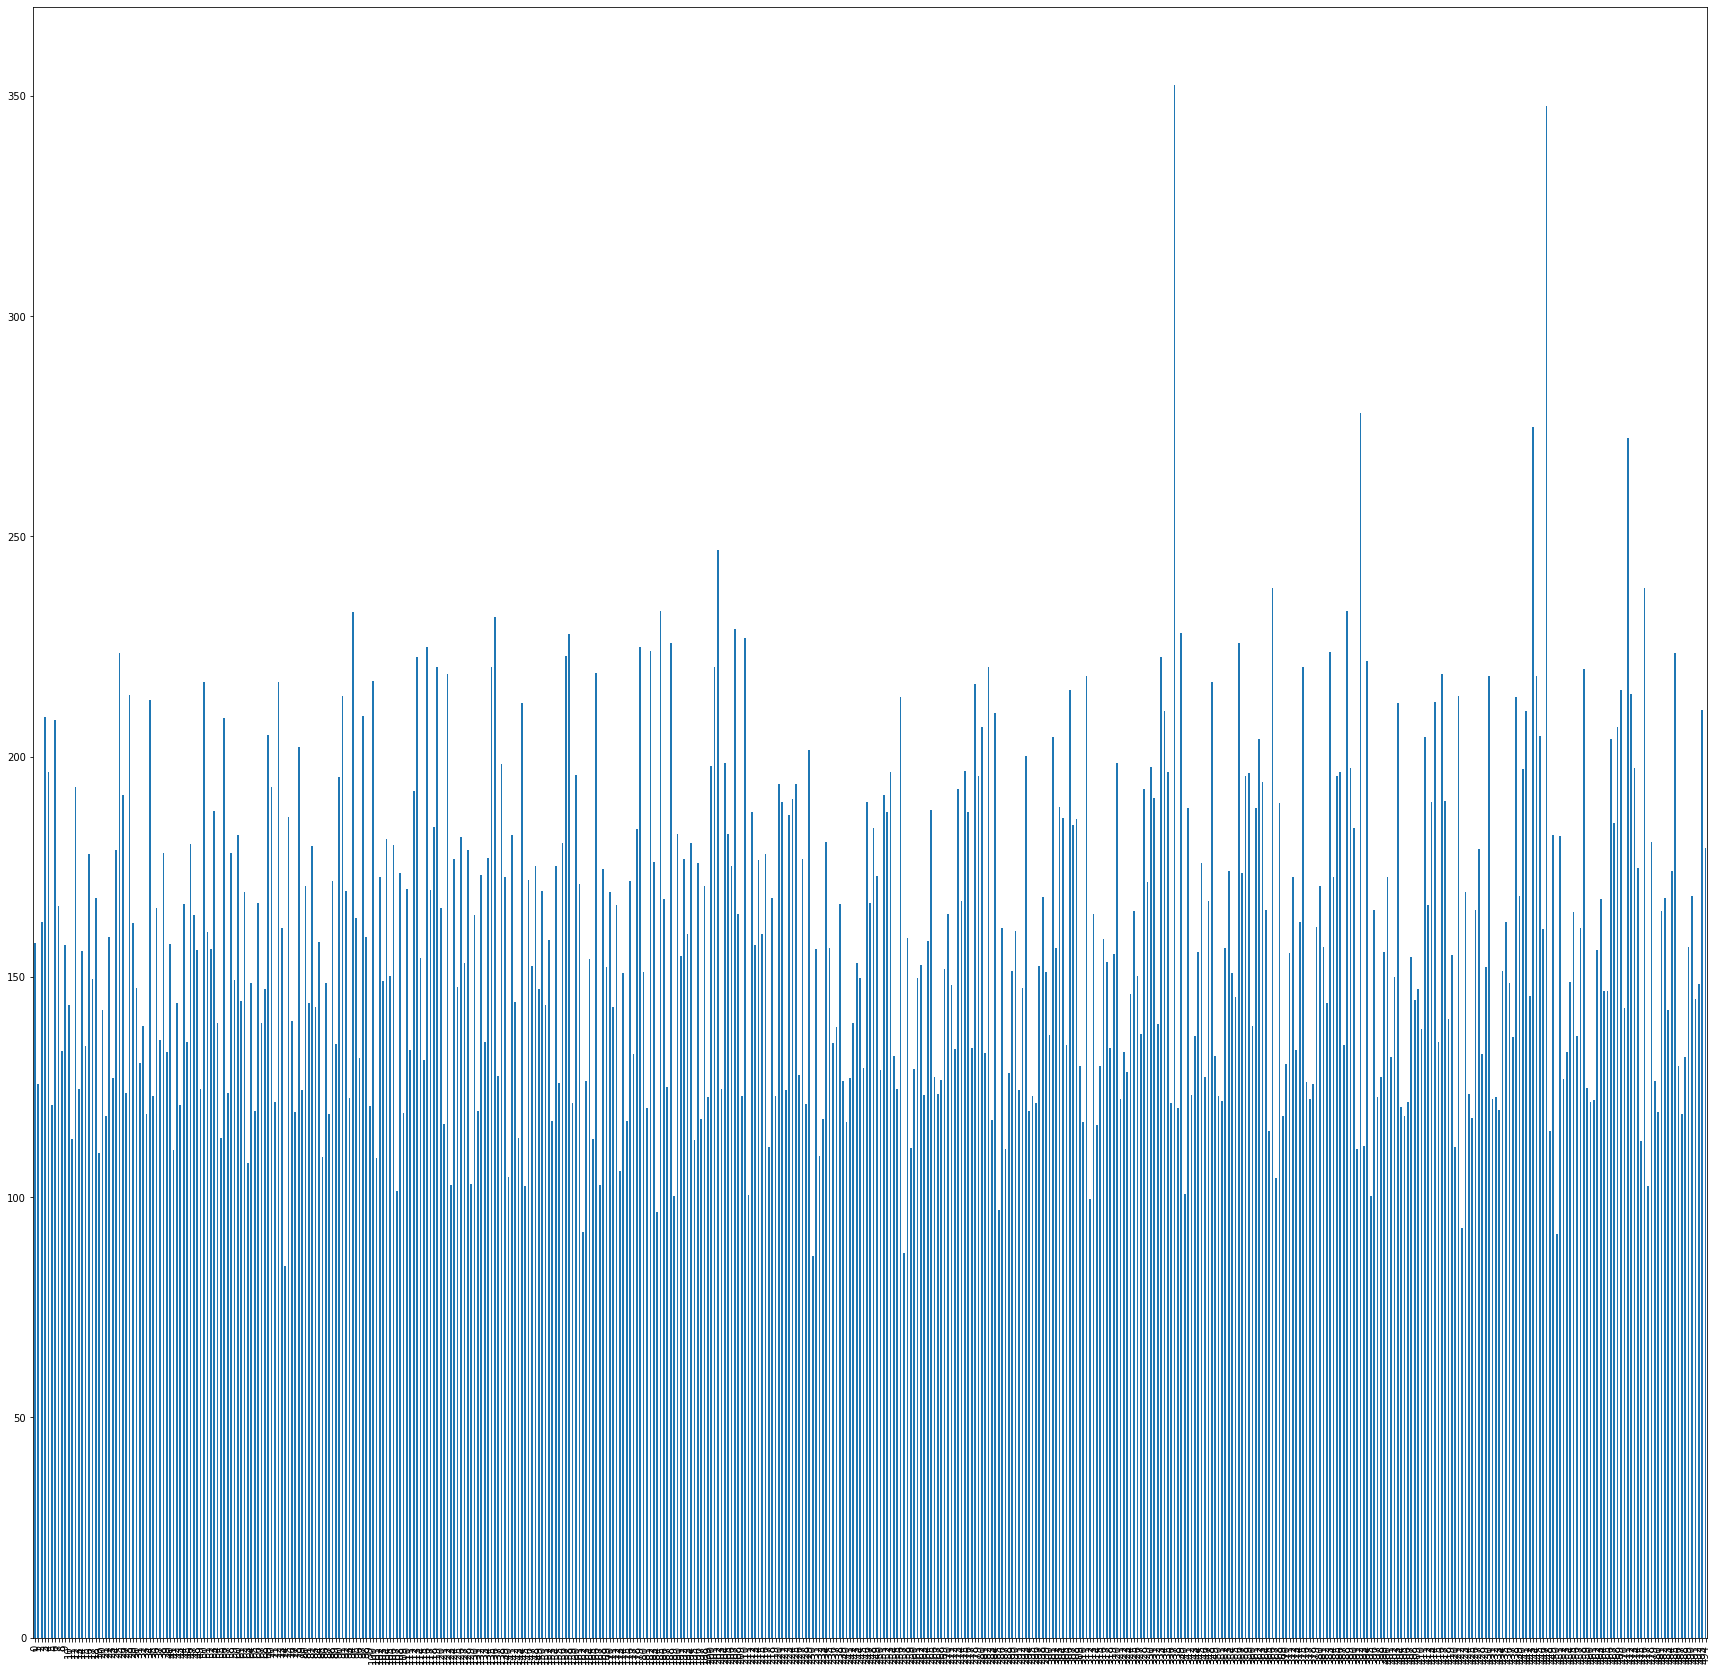

In [6]:
df['meanF0Hz'].plot(kind="bar", figsize=(30, 30))

In [4]:
# shape
print(df.shape)

# descriptions
print(df.describe())

# class distribution
print(df.groupby('label').size())

(495, 14)
         meanF0Hz     maxF0Hz     minF0Hz  localJitter  localabsoluteJitter  \
count  495.000000  495.000000  495.000000   495.000000           495.000000   
mean   160.473070  195.859538  123.610666     0.005996             0.000040   
std     38.169923   71.835275   39.598544     0.007772             0.000056   
min     84.408403   91.662939   65.717310     0.001137             0.000005   
25%    128.270146  145.875285   89.547838     0.003015             0.000018   
50%    156.765344  181.437129  115.892342     0.004088             0.000027   
75%    185.435788  224.147188  154.037203     0.006082             0.000043   
max    352.604230  497.225757  264.076484     0.097030             0.000747   

        rapJitter   ddpJitter  localShimmer  localdbShimmer  apq3Shimmer  \
count  495.000000  495.000000    495.000000      495.000000   495.000000   
mean     0.003160    0.009481      0.041178        0.387851     0.019977   
std      0.004572    0.013715      0.037864       

### EDA - Check outliers Visualization

<Figure size 2160x2160 with 0 Axes>

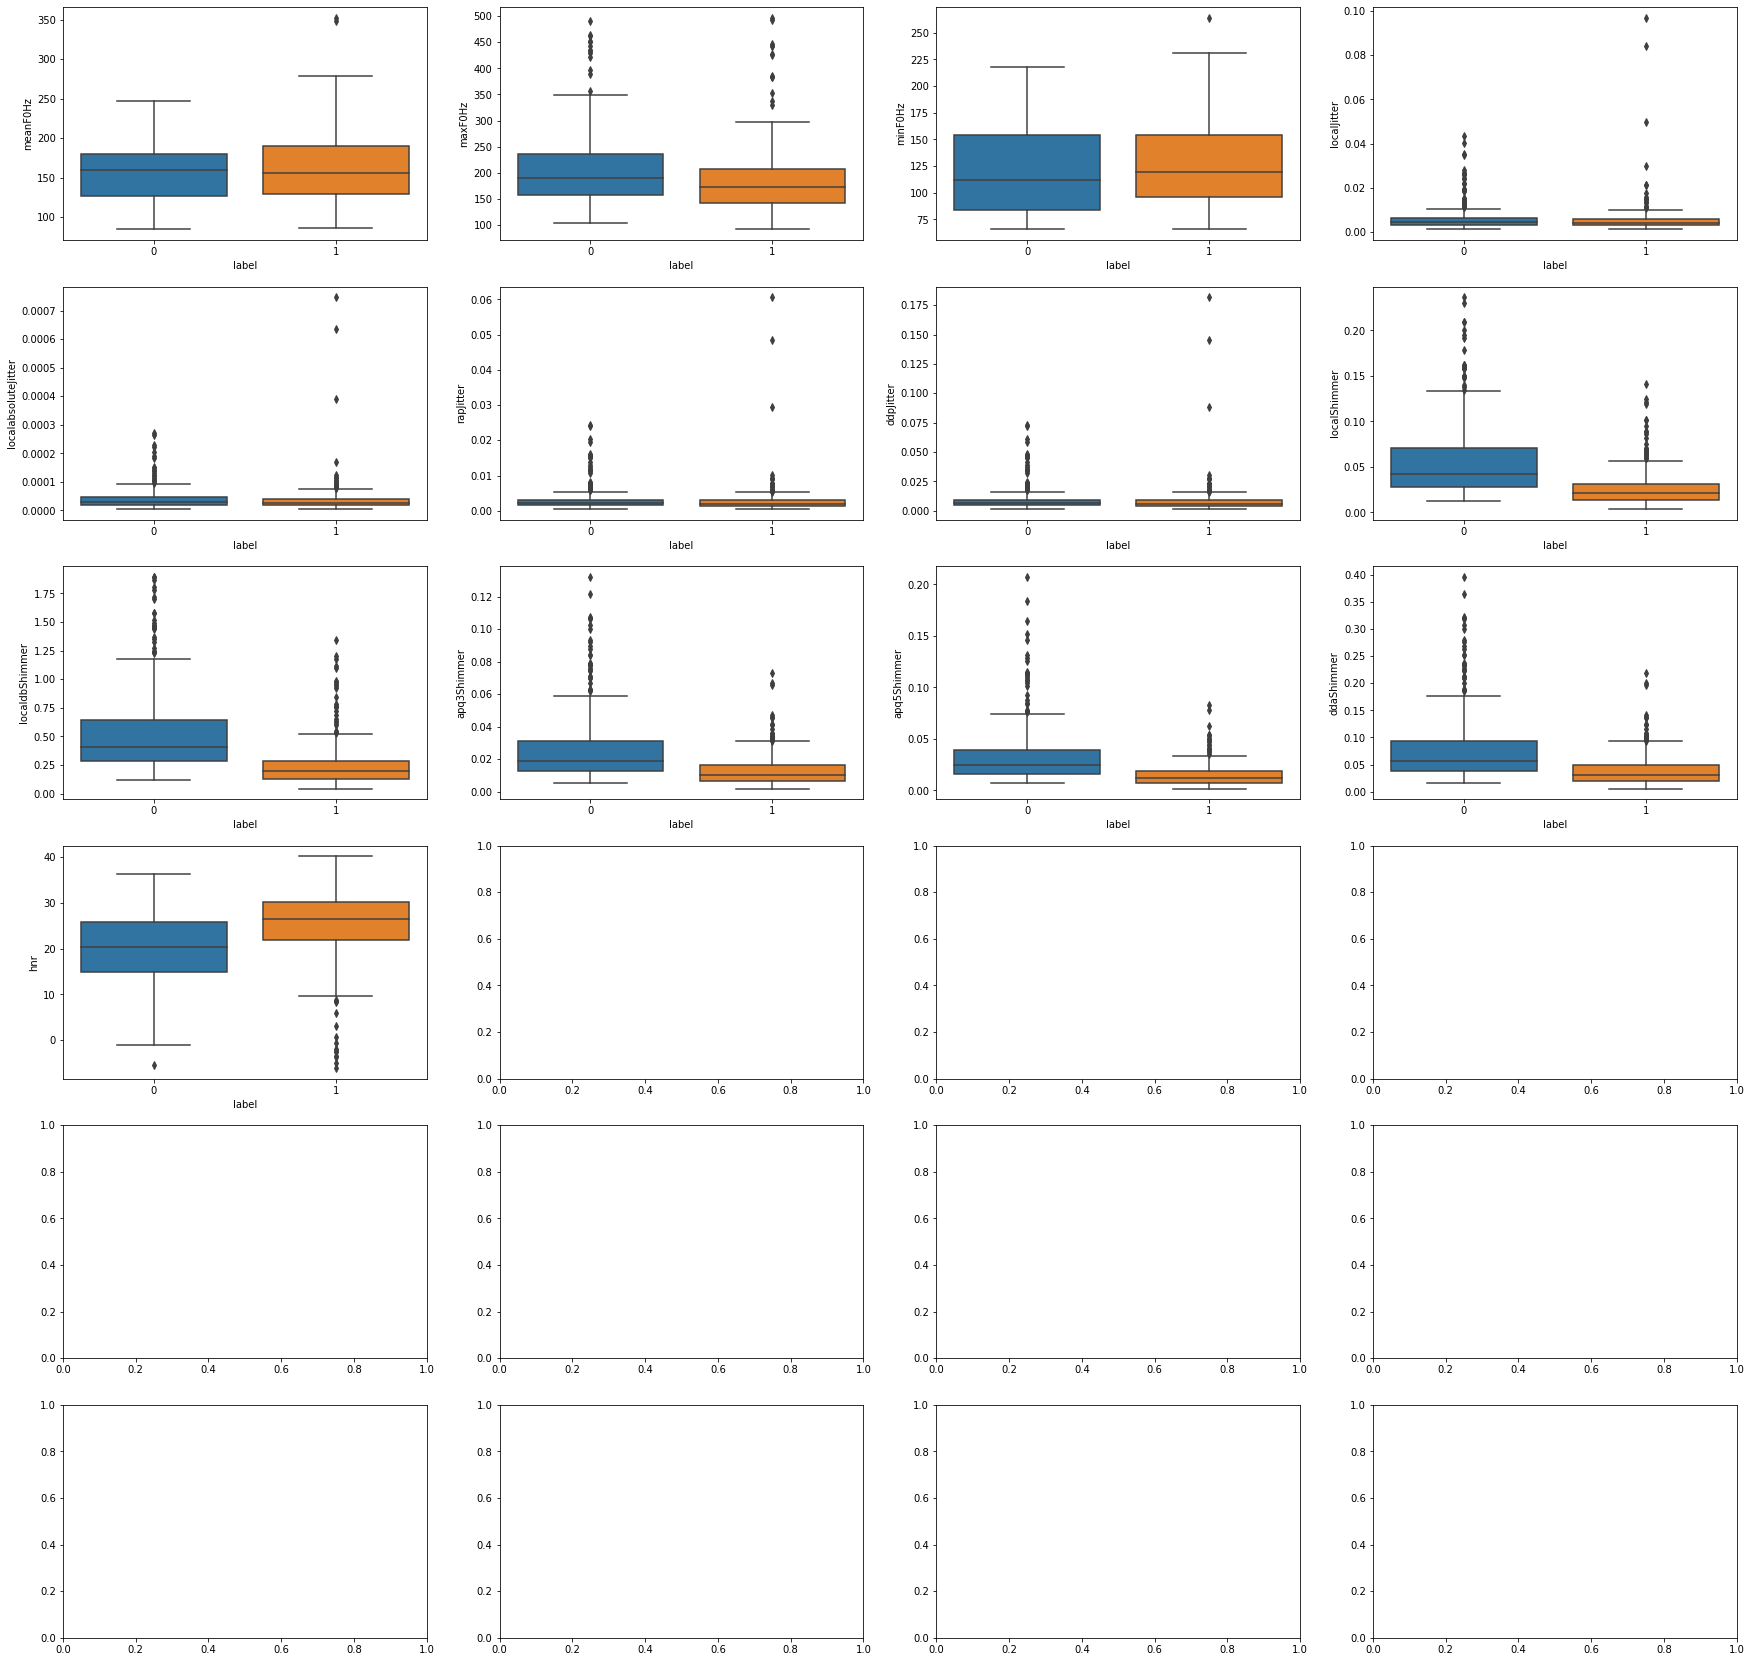

In [6]:
# histograms
plt.figure(figsize=(30,30))
#df_all.hist(figsize=(30,30))
#plt.show()

#box plot to check outliers
cols = df.columns.drop('label')
fig, ax = plt.subplots(6,4, figsize=(30,30))
for i,t in enumerate(cols):
    sns.boxplot(y=t, x= "label", data=df, ax=ax[i//4,i % 4])
plt.show()




In [7]:
df_jitter = df.sort_values("localabsoluteJitter")
Q1=df_jitter['localabsoluteJitter'].quantile(0.25)
Q3=df_jitter['localabsoluteJitter'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1 - 1.5*IQR
Upper_Whisker = Q3 + 1.5*IQR

df_1 = df_jitter[df_jitter['localabsoluteJitter'] > Upper_Whisker]
df_1.append(df_jitter[df_jitter['localabsoluteJitter'] < Lower_Whisker])
df_1

1.757506220539253e-05
4.267864775651257e-05
2.5103585551120043e-05


,meanF0Hz,maxF0Hz,minF0Hz,localJitter,localabsoluteJitter,rapJitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,ddaShimmer,hnr,label
155,125.950330,132.518787,121.132967,0.010163,0.000081,0.006068,0.018205,0.106211,1.046138,0.054886,0.068186,0.164657,14.473288,0
282,220.310685,352.211418,113.620651,0.017603,0.000081,0.004799,0.014397,0.101188,0.957116,0.034059,0.051000,0.102177,17.001733,1
23,126.963367,139.284595,89.843961,0.010385,0.000082,0.005791,0.017372,0.075504,0.756803,0.035499,0.046721,0.106496,16.135353,0
177,132.463842,397.116154,75.571529,0.011111,0.000084,0.005939,0.017817,0.066397,0.828421,0.029961,0.034050,0.089883,21.167531,0
235,156.617660,210.287700,142.195327,0.013315,0.000085,0.006931,0.020792,0.062578,0.596823,0.033766,0.039516,0.101298,17.206717,1
329,171.617707,176.729194,166.689803,0.014730,0.000086,0.008916,0.026748,0.045906,0.401694,0.026115,0.027442,0.078344,22.649318,1
133,135.259477,450.294606,81.669731,0.011245,0.000086,0.006262,0.018785,0.081892,1.013191,0.042020,0.048056,0.126060,17.454519,0
127,153.185526,162.804070,143.381011,0.013213,0.000086,0.007573,0.022718,0.072177,0.763837,0.030965,0.040130,0.092894,17.389242,0
113,222.600797,243.427942,200.880427,0.019346,0.000087,0.011167,0.033502,0.162263,1.472109,0.087983,0.104530,0.263948,18.185055,0
9,157.207001,463.344794,83.745546,0.013217,0.000088,0.006784,0.020351,0.097029,0.949460,0.047393,0.058568,0.142178,12.418897,0


### Split dataset

In [8]:
#separate dependent and independent variable for acoustic features only
X = df.iloc[:, :-1]
df_X = df.iloc[:, :-1].values
df_Y = df.iloc[:,-1].values

# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size = 0.3, random_state = 0)

### Feature scaling

In [9]:
# Scale for acoustic features
#sc = StandardScaler()
sc = MinMaxScaler()
#sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.129107,0.086154,0.252258,0.029157,0.038438,0.022437,0.022437,0.182471,0.181905,0.125176,0.123145,0.125176,0.586119
1,0.358913,0.383864,0.184551,0.025443,0.020079,0.022913,0.022913,0.206806,0.250407,0.175907,0.114991,0.175907,0.717132
2,0.315744,0.211125,0.502401,0.037912,0.031624,0.038853,0.038853,0.087683,0.087644,0.071783,0.064585,0.071783,0.853661
3,0.502459,0.336491,0.444443,0.154127,0.092099,0.161068,0.161068,0.618825,0.716054,0.629960,0.509199,0.629960,0.393803
4,0.169580,0.117856,0.307564,0.013653,0.019097,0.010803,0.010803,0.031414,0.031804,0.019474,0.017622,0.019474,0.858914
...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,0.156710,0.109930,0.239309,0.024663,0.031146,0.022660,0.022660,0.043129,0.045509,0.028808,0.026764,0.028808,0.650311
342,0.338745,0.243560,0.121827,0.013785,0.012240,0.016752,0.016752,0.056253,0.069269,0.052759,0.034514,0.052759,0.871946
343,0.312204,0.203049,0.344687,0.022591,0.019929,0.020716,0.020716,0.239456,0.261901,0.232657,0.171423,0.232657,0.582258
344,0.290761,0.342847,0.023730,0.043060,0.061615,0.038318,0.038318,0.459209,0.491016,0.464095,0.362999,0.464095,0.439059


# *****************KNN Experiments******************

## Build model
### without tuning the hyperparameters

In [10]:
###### KNNN ###########
# Fit classifier to the Training set
#KNN
model_knn = KNeighborsClassifier(n_neighbors = 10)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn = ((conf_matrix_knn[0,0] + conf_matrix_knn[1,1])/(conf_matrix_knn[0,0] +conf_matrix_knn[0,1]+conf_matrix_knn[1,0]+conf_matrix_knn[1,1]))*100


print(accuracy_knn)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn))

print(y_pred_knn)

print(conf_matrix_knn)



79.19463087248322
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        61
           1       0.85      0.78      0.82        88

    accuracy                           0.79       149
   macro avg       0.79      0.79      0.79       149
weighted avg       0.80      0.79      0.79       149

0.7936847988077497
[1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1
 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1
 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1
 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1
 1]
[[49 12]
 [19 69]]


## Hyperparameter tuning for KNN

In [11]:
########Hyperparameter tuning for KNN####################
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,20)) #neighbours must be < number of samples (22)
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

Best leaf_size: 1
Best p: 2
Best n_neighbors: 1
Best Score: 0.8265895953757225
Best Hyperparameters: {'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
{'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'p': [1, 2]}
80.53691275167785
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        61
           1       0.86      0.80      0.83        88

    accuracy                           0.81       149
   macro avg       0.80      0.81      0.80       149
weighted avg       0.81      0.81      0.81       149

0.8075633383010432
[0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1
 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1
 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Build Model
### using the optimal parameters gotten above

In [13]:
model_knn = KNeighborsClassifier(n_neighbors = 1, p = 2, leaf_size = 1)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn = ((conf_matrix_knn[0,0] + conf_matrix_knn[1,1])/(conf_matrix_knn[0,0] +conf_matrix_knn[0,1]+conf_matrix_knn[1,0]+conf_matrix_knn[1,1]))*100


print(accuracy_knn)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn))

print(y_pred_knn)
print(y_test)

print(conf_matrix_knn)

####################using the acoustic + MFCC


80.53691275167785
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        61
           1       0.86      0.80      0.83        88

    accuracy                           0.81       149
   macro avg       0.80      0.81      0.80       149
weighted avg       0.81      0.81      0.81       149

0.8075633383010432
[0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1
 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1
 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1
 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1
 1]
[0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1
 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1
 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1
 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1
 1]
[[50 11]
 [18 70]]


## Evaluation 


### Evaluation with Leave one out method -IGNORE

In [ ]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
model_knn_kfold = KNeighborsClassifier(n_neighbors = 9, p =1, leaf_size = 1)
y_pred_kfold_knn = cross_val_predict(model_knn_kfold, df_X, df_Y, cv=k_fold)

scores = cross_val_score(model_knn_kfold, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_knn)
conf_matrix_knn_kfold = confusion_matrix(df_Y, y_pred_kfold_knn)
print("Confusion Matrix for KNN using k-fold (leave one out)")
print(conf_matrix_knn_kfold)


accuracy_knn_2 = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/(conf_matrix_knn_kfold[0,0] +conf_matrix_knn_kfold[0,1]+conf_matrix_knn_kfold[1,0]+conf_matrix_knn_kfold[1,1]))*100


print(accuracy_knn_2)

### K Fold Evaluation using optimal paramaters. (k =4)


In [38]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_list = []
k_specificity = []
k_sensitivity = []
k_precision = []
k_f1 = []
for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        print('\ntrain: %s, test: %s' % (train.size, test.size))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)
        #print(Ytrain_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        model_knn_new = KNeighborsClassifier(n_neighbors = 1, p =2, leaf_size = 1)
        model_knn_new.fit(Xtrain_kfold, Ytrain_kfold)
        y_pred_knn_new = model_knn_new.predict(Xtest_kfold)

        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_knn_new)
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
        
        #total = (conf_matrix_knn_kfold[0,0] +conf_matrix_knn_kfold[0,1]+conf_matrix_knn_kfold[1,0]+conf_matrix_knn_kfold[1,1])

        #accuracy_knn_kfold = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/total)*100
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) * 100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))
        #sensitivity_knn_kfold = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/total)*100

        #print("Confusion Matrix:\n ", conf_matrix_knn_kfold)
        #print("Accuracy ", accuracy_knn_kfold)

        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold
        
        #plot roc only for the first iteration
        #if i == 1:
           # metrics.plot_roc_curve(model_knn_new, Xtest_kfold, Ytest_kfold,name='ROC fold {}'.format(j),
                     #    alpha=0.3, lw=1, ax=ax)
        
        
    average = row.append(total/parts)
    
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_list.append(row)
    k_specificity.append(row_specificity)
    k_sensitivity.append(row_sensitivity)
    k_precision.append(row_precision)
    k_f1.append(row_f1)
    
      
k_list = pd.DataFrame(k_list, columns=['Iteration','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Classification Accuracy")
print(k_list)
    

k_specificity = pd.DataFrame(k_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_specificity)

k_sensitivity = pd.DataFrame(k_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_sensitivity)

k_precision = pd.DataFrame(k_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_precision)

k_f1 = pd.DataFrame(k_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_f1)
    
k_list
    
#print(df.sample(n=7))
#print(df)

#x = df.take(np.random.permutation(len(df))[:4])
#x= df.sample(n=7)
#print(x)
#print(df.drop(x))

#drop_indices = np.random.choice(df.index, 4, replace=False)
#df_subset = df.drop(drop_indices)
#print(drop_indices)
#print(df_subset)

    
    


Divided into 4 parts.

train: 371, test: 124

train: 371, test: 124

train: 371, test: 124

train: 372, test: 123

train: 371, test: 124

train: 371, test: 124

train: 371, test: 124

train: 372, test: 123

train: 371, test: 124

train: 371, test: 124

train: 371, test: 124

train: 372, test: 123

train: 371, test: 124

train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A c


train: 371, test: 124

train: 372, test: 123

train: 371, test: 124

train: 371, test: 124

train: 371, test: 124

train: 372, test: 123

train: 371, test: 124

train: 371, test: 124

train: 371, test: 124

train: 372, test: 123

train: 371, test: 124

C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A c



train: 371, test: 124

train: 371, test: 124

train: 372, test: 123

train: 371, test: 124

train: 371, test: 124

train: 371, test: 124

train: 372, test: 123

train: 371, test: 124

train: 371, test: 124

train: 371, test: 124

train: 372, test: 123

train: 371, test: 124

train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A c


train: 371, test: 124

train: 372, test: 123

train: 371, test: 124

train: 371, test: 124

train: 371, test: 124

train: 372, test: 123
KNN Kfold Evaluation for MDVR-KCL Dataset - Classification Accuracy
    Iteration     fold 1     fold 2     fold 3     fold 4  mean accuracy
0           1  79.838710  83.870968  81.451613  78.048780      80.802518
1           2  79.838710  82.258065  81.451613  82.113821      81.415552
2           3  80.645161  79.032258  76.612903  83.739837      80.007540
3           4  80.645161  81.451613  77.419355  85.365854      81.220496
4           5  78.225806  87.096774  87.903226  78.861789      83.021899
5           6  84.677419  87.096774  85.483871  82.113821      84.842971
6           7  78.225806  79.032258  79.838710  83.739837      80.209153
7           8  83.870968  80.645161  80.645161  79.674797      81.209022
8           9  79.838710  79.838710  83.870968  84.552846      82.025308
9          10  79.838710  80.645161  81.451613  83.739837      8

C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A c

,Iteration,fold 1,fold 2,fold 3,fold 4,mean accuracy
0,1,79.838710,83.870968,81.451613,78.048780,80.802518
1,2,79.838710,82.258065,81.451613,82.113821,81.415552
2,3,80.645161,79.032258,76.612903,83.739837,80.007540
3,4,80.645161,81.451613,77.419355,85.365854,81.220496
4,5,78.225806,87.096774,87.903226,78.861789,83.021899
5,6,84.677419,87.096774,85.483871,82.113821,84.842971
6,7,78.225806,79.032258,79.838710,83.739837,80.209153
7,8,83.870968,80.645161,80.645161,79.674797,81.209022
8,9,79.838710,79.838710,83.870968,84.552846,82.025308
9,10,79.838710,80.645161,81.451613,83.739837,81.418830



# *****************Decision Tree Experiments***************

## Build model
### without tuning the hyperparameters

79.19463087248322
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        61
           1       0.84      0.80      0.82        88

    accuracy                           0.79       149
   macro avg       0.79      0.79      0.79       149
weighted avg       0.80      0.79      0.79       149

0.7911698956780924
[0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1
 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1
 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1
 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1
 1]
[[48 13]
 [18 70]]


[Text(563.8736842105263, 722.9879999999999, 'X[8] <= 0.109\ngini = 0.497\nsamples = 346\nvalue = [159, 187]'),
 Text(160.05789473684212, 646.884, 'X[7] <= 0.05\ngini = 0.3\nsamples = 147\nvalue = [27, 120]'),
 Text(46.98947368421053, 570.78, 'X[8] <= 0.043\ngini = 0.061\nsamples = 63\nvalue = [2, 61]'),
 Text(23.494736842105265, 494.676, 'gini = 0.0\nsamples = 48\nvalue = [0, 48]'),
 Text(70.48421052631579, 494.676, 'X[3] <= 0.014\ngini = 0.231\nsamples = 15\nvalue = [2, 13]'),
 Text(46.98947368421053, 418.57199999999995, 'X[2] <= 0.449\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(23.494736842105265, 342.46799999999996, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(70.48421052631579, 342.46799999999996, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(93.97894736842106, 418.57199999999995, 'gini = 0.0\nsamples = 12\nvalue = [0, 12]'),
 Text(273.1263157894737, 570.78, 'X[3] <= 0.019\ngini = 0.418\nsamples = 84\nvalue = [25, 59]'),
 Text(164.46315789473687, 494.676, 'X[12] <=

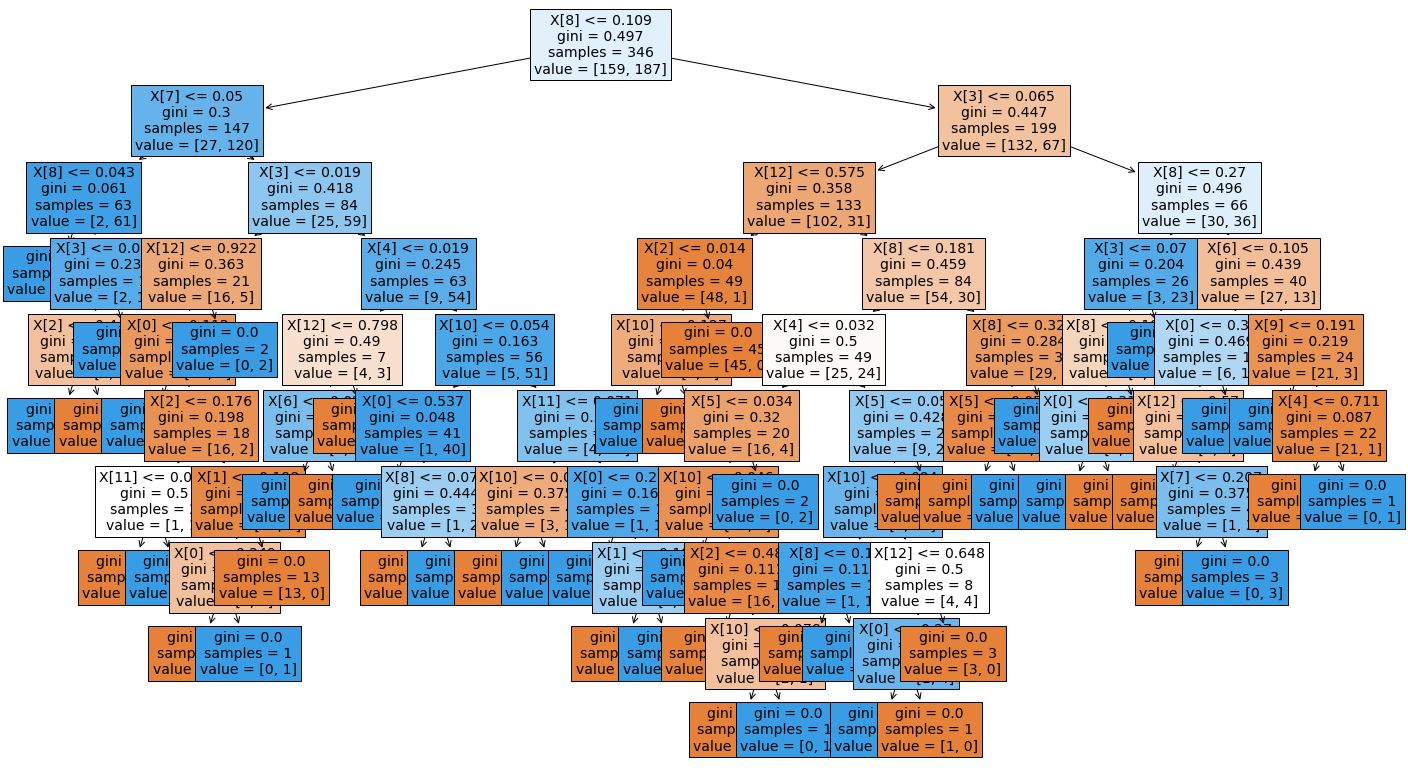

In [16]:
###### KNNN ###########
# Fit classifier to the Training set
#Decision Tree
import matplotlib.pyplot as plt
model_dt = tree.DecisionTreeClassifier()
model_dt = model_dt.fit(X_train, y_train)

y_pred_knn = model_dt.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn = ((conf_matrix_knn[0,0] + conf_matrix_knn[1,1])/(conf_matrix_knn[0,0] +conf_matrix_knn[0,1]+conf_matrix_knn[1,0]+conf_matrix_knn[1,1]))*100


print(accuracy_knn)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn))

print(y_pred_knn)

print(conf_matrix_knn)

plt.figure(figsize=(24,14))
tree.plot_tree(model_dt, filled=True, fontsize=14)

## Hyperparameter tuning for Decision Trees

In [17]:
########Hyperparameter tuning for KNN####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
max_depth = list(range(1,10))
min_samples_split = list(range(2,10)) #neighbours must be < number of samples (22)
min_samples_leaf = list(range(1,5))
criterion=['gini','entropy']
#Convert to dictionary
hyperparameters = dict(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, criterion = criterion)
#Create new KNN object
dt_2 = tree.DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(dt_2, hyperparameters, refit=True)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score: 0.7976878612716763
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 5}
{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [1, 2, 3, 4], 'criterion': ['gini', 'entropy']}
81.87919463087249
              precision    recall  f1-score   support

           0       0.78      0.77      0.78        61
           1       0.84      0.85      0.85        88

    accuracy                           0.82       149
   macro avg       0.81      0.81      0.81       149
weighted avg       0.82      0.82      0.82       149

0.8113822652757079
[1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1
 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1
 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1
 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1
 1]
[0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Build Model (Decision Tree)
### using the optimal parameters gotten above

In [18]:
#model_dt = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_dt = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=3, min_samples_split=5 )
model_dt = model_dt.fit(X_train, y_train)

y_pred_dt_2 = best_model.predict(X_test)

conf_matrix_dt_2 = confusion_matrix(y_test, y_pred_dt_2)

accuracy_dt_2 = ((conf_matrix_dt_2[0,0] + conf_matrix_dt_2[1,1])/(conf_matrix_dt_2[0,0] +conf_matrix_dt_2[0,1]+conf_matrix_dt_2[1,0]+conf_matrix_dt_2[1,1]))*100

print(conf_matrix_dt_2)
print(accuracy_dt_2)

[[47 14]
 [13 75]]
81.87919463087249


## Evaluation 


### Evaluation with Leave one out method - IGNORE

In [ ]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
#model_knn_kfold = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_dt = tree.DecisionTreeClassifier(max_depth = 1, criterion='gini',min_samples_leaf=1, min_samples_split=2 )
y_pred_kfold_knn = cross_val_predict(model_dt, df_X, df_Y, cv=k_fold)
scores = cross_val_score(model_dt, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_knn)
conf_matrix_knn_kfold = confusion_matrix(df_Y, y_pred_kfold_knn)
print("Confusion Matrix for Dt using k-fold (leave one out)")
print(conf_matrix_knn_kfold)


accuracy_knn_2 = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/(conf_matrix_knn_kfold[0,0] +conf_matrix_knn_kfold[0,1]+conf_matrix_knn_kfold[1,0]+conf_matrix_knn_kfold[1,1]))*100


print(accuracy_knn_2)

### K Fold Evaluation using optimal paramaters. (k =4)


In [19]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_dt_list = []
k_dt_specificity = []
k_dt_sensitivity = []
k_dt_precision = []
k_dt_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        #model_knn_new = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
        model_dt_new = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=3, min_samples_split=5 )
        model_dt_new.fit(Xtrain_kfold, Ytrain_kfold)
        y_pred_dt_new = model_dt_new.predict(Xtest_kfold)

        #conf_matrix_dt_kfold = confusion_matrix(Ytest_kfold, y_pred_dt_new)
        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_dt_new)

        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_dt_list.append(row)
    k_dt_specificity.append(row_specificity)
    k_dt_sensitivity.append(row_sensitivity)
    k_dt_precision.append(row_precision)
    k_dt_f1.append(row_f1)
    
k_dt_list = pd.DataFrame(k_dt_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Decsion Tree Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_dt_list)    

k_dt_specificity = pd.DataFrame(k_dt_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("Decsion Tree Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_dt_specificity)

k_dt_sensitivity = pd.DataFrame(k_dt_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("Decsion Tree Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_dt_sensitivity)

k_dt_precision = pd.DataFrame(k_dt_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("Decsion Tree Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_dt_precision)

k_dt_f1 = pd.DataFrame(k_dt_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("Decsion Tree Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_dt_f1)


    
    
    

    
    


Divided into 4 parts.
Decsion Tree Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy
    Loops     fold 1     fold 2     fold 3     fold 4  mean accuracy
0       1  83.064516  78.225806  75.000000  75.609756      77.975020
1       2  80.645161  72.580645  84.677419  73.983740      77.971741
2       3  74.193548  78.225806  75.806452  73.983740      75.552387
3       4  75.806452  75.000000  78.225806  78.048780      76.770260
4       5  74.193548  70.967742  73.387097  74.796748      73.336284
5       6  76.612903  69.354839  74.193548  69.105691      72.316745
6       7  77.419355  75.000000  81.451613  77.235772      77.776685
7       8  83.064516  74.193548  75.806452  83.739837      79.201088
8       9  73.387097  81.451613  85.483871  73.170732      78.373328
9      10  80.645161  77.419355  75.000000  79.674797      78.184828
10     11  79.838710  74.193548  83.870968  76.422764      78.581498
Decsion Tree Kfold Evaluation for MDVR-KCL Dataset - Specificity
    Loops 


# *****************SVM Experiments***************

## Build model
### without tuning the hyperparameters

In [20]:
###### KNNN ###########
# Fit classifier to the Training set
#Decision Tree
import matplotlib.pyplot as plt
model_svm = svm.SVC()
model_svm = model_dt.fit(X_train, y_train)

y_pred_svm = model_dt.predict(X_test)

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

accuracy_svm = ((conf_matrix_svm[0,0] + conf_matrix_svm[1,1])/(conf_matrix_svm[0,0] +conf_matrix_svm[0,1]+conf_matrix_svm[1,0]+conf_matrix_svm[1,1]))*100


print(accuracy_svm)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_svm))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_svm))

print(y_pred_svm)

print(conf_matrix_svm)


79.86577181208054
              precision    recall  f1-score   support

           0       0.77      0.72      0.75        61
           1       0.82      0.85      0.83        88

    accuracy                           0.80       149
   macro avg       0.79      0.79      0.79       149
weighted avg       0.80      0.80      0.80       149

0.7867921013412816
[1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1
 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1
 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1
 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1
 1]
[[44 17]
 [13 75]]


## Hyperparameter tuning for SVM

In [21]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
kernel = ['rbf']

#Convert to dictionary
hyperparameters = dict(C=C, gamma=gamma, kernel=kernel)
#Create new KNN object
svm2 = svm.SVC()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(svm2, hyperparameters, refit=True)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score: 0.861271676300578
Best Hyperparameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
88.59060402684564
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        61
           1       0.89      0.92      0.91        88

    accuracy                           0.89       149
   macro avg       0.88      0.88      0.88       149
weighted avg       0.89      0.89      0.89       149

0.8782600596125186
[1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1
 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1
 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1
 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1
 1]
[0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1
 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1


## Build Model (SVM)
### using the optimal parameters gotten above

In [22]:
model_svm = svm.SVC(C = 100, gamma=1,kernel='rbf')
model_svm = model_svm.fit(X_train, y_train)

y_pred_svm_2 = best_model.predict(X_test)

conf_matrix_svm_2 = confusion_matrix(y_test, y_pred_svm_2)

accuracy_svm_2 = ((conf_matrix_svm_2[0,0] + conf_matrix_svm_2[1,1])/(conf_matrix_svm_2[0,0] +conf_matrix_svm_2[0,1]+conf_matrix_svm_2[1,0]+conf_matrix_svm_2[1,1]))*100

print(conf_matrix_svm_2)
print(accuracy_svm_2)

[[51 10]
 [ 7 81]]
88.59060402684564


## Evaluation (SVM) 


### Evaluation with Leave one out method

In [ ]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
#model_knn_kfold = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_svm = svm.SVC(C = 100, gamma=1,kernel='rbf')
y_pred_kfold_svm = cross_val_predict(model_svm, df_X, df_Y, cv=k_fold)
scores = cross_val_score(model_svm, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_knn)
conf_matrix_svm_kfold = confusion_matrix(df_Y, y_pred_kfold_svm)
print("Confusion Matrix for Dt using k-fold (leave one out)")
print(conf_matrix_svm_kfold)


accuracy_svm_2 = ((conf_matrix_svm_kfold[0,0] + conf_matrix_svm_kfold[1,1])/(conf_matrix_svm_kfold[0,0] +conf_matrix_svm_kfold[0,1]+conf_matrix_svm_kfold[1,0]+conf_matrix_svm_kfold[1,1]))*100


print(accuracy_svm_2)

### K Fold Evaluation using optimal paramaters. (k =4)


In [23]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_svm_list = []
k_svm_specificity = []
k_svm_sensitivity = []
k_svm_precision = []
k_svm_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        
        model_svm_new = svm.SVC(C = 100, gamma=1,kernel='rbf')
        model_svm_new.fit(Xtrain_kfold, Ytrain_kfold)
        y_pred_svm_new = model_svm_new.predict(Xtest_kfold)

        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_svm_new)

        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_svm_list.append(row)
    k_svm_specificity.append(row_specificity)
    k_svm_sensitivity.append(row_sensitivity)
    k_svm_precision.append(row_precision)
    k_svm_f1.append(row_f1)
    
k_svm_list = pd.DataFrame(k_svm_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_svm_list)    

k_svm_specificity = pd.DataFrame(k_svm_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_svm_specificity)

k_svm_sensitivity = pd.DataFrame(k_svm_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_svm_sensitivity)

k_svm_precision = pd.DataFrame(k_svm_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_svm_precision)

k_svm_f1 = pd.DataFrame(k_svm_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_svm_f1)

Divided into 4 parts.


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

SVM Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy
    Loops     fold 1     fold 2     fold 3     fold 4  mean accuracy
0       1  87.096774  83.870968  86.290323  89.430894      86.672240
1       2  91.129032  80.645161  91.129032  86.178862      87.270522
2       3  88.709677  83.064516  87.903226  82.926829      85.651062
3       4  85.483871  88.709677  90.322581  89.430894      88.486756
4       5  84.677419  91.129032  83.870968  91.056911      87.683582
5       6  90.322581  85.483871  87.903226  88.617886      88.081891
6       7  85.483871  83.870968  87.903226  91.056911      87.078744
7       8  87.096774  89.516129  84.677419  92.682927      88.493312
8       9  85.483871  87.096774  87.903226  86.178862      86.665683
9      10  84.677419  86.290323  87.096774  87.804878      86.467349
10     11  87.903226  87.096774  85.483871  86.178862      86.665683
SVM Kfold Evaluation for MDVR-KCL Dataset - Specificity
    Loops     fold 1     fold 2     fold 3     fol

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,


# *****************Naive Bayes Experiments***************

## Build model
### without tuning the hyperparameters

In [24]:
###### KNNN ###########
# Fit classifier to the Training set
#NB
model_nb = GaussianNB()
model_nb = model_nb.fit(X_train, y_train)


y_pred_nb = model_nb.predict(X_test)

conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

accuracy_nb = ((conf_matrix_nb[0,0] + conf_matrix_nb[1,1])/(conf_matrix_nb[0,0] +conf_matrix_nb[0,1]+conf_matrix_nb[1,0]+conf_matrix_nb[1,1]))*100


print(accuracy_nb)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_nb))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_nb))

print(y_pred_nb)

print(conf_matrix_nb)


69.79865771812081
              precision    recall  f1-score   support

           0       0.79      0.36      0.49        61
           1       0.68      0.93      0.78        88

    accuracy                           0.70       149
   macro avg       0.73      0.65      0.64       149
weighted avg       0.72      0.70      0.67       149

0.6462369597615498
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1
 1]
[[22 39]
 [ 6 82]]


## Hyperparameter tuning for Naive Bayes

### NB doesnt have important parameters to tune

## Evaluation (Naive Bayes) 


### Evaluation with Leave one out method

In [7]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
#model_knn_kfold = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_nb_2 = GaussianNB()
y_pred_kfold_nb = cross_val_predict(model_nb_2, df_X, df_Y, cv=k_fold)
scores = cross_val_score(model_nb_2, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_nb)
conf_matrix_nb_kfold = confusion_matrix(df_Y, y_pred_kfold_nb)
print("Confusion Matrix for Dt using k-fold (leave one out)")
print(conf_matrix_nb_kfold)


accuracy_nb_2 = ((conf_matrix_nb_kfold[0,0] + conf_matrix_nb_kfold[1,1])/(conf_matrix_nb_kfold[0,0] +conf_matrix_nb_kfold[0,1]+conf_matrix_nb_kfold[1,0]+conf_matrix_nb_kfold[1,1]))*100


print(accuracy_nb_2)

Accuracy: 0.757 (0.429)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0]
Confusion Matrix for Dt using k-fold (leave one out)
[[17  4]
 [ 5 11]]
75.67567567567568


### K Fold Evaluation using optimal paramaters. (k =4)


In [25]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_nb_list = []
k_nb_specificity = []
k_nb_sensitivity = []
k_nb_precision = []
k_nb_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        
        model_nb_new = GaussianNB()
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_nb_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)

        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_nb_kfold[0][0]
        FP = conf_matrix_nb_kfold[0][1]
        FN = conf_matrix_nb_kfold[1][0]
        TP = conf_matrix_nb_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_nb_list.append(row)
    k_nb_specificity.append(row_specificity)
    k_nb_sensitivity.append(row_sensitivity)
    k_nb_precision.append(row_precision)
    k_nb_f1.append(row_f1)
    
k_nb_list = pd.DataFrame(k_nb_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Naive Bayes Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_nb_list)    

k_nb_specificity = pd.DataFrame(k_nb_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("Naive Bayes Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_nb_specificity)

k_nb_sensitivity = pd.DataFrame(k_nb_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("Naive Bayes Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_nb_sensitivity)

k_nb_precision = pd.DataFrame(k_nb_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("Naive Bayes Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_nb_precision)

k_nb_f1 = pd.DataFrame(k_nb_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("Naive Bayes Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_nb_f1)

Divided into 4 parts.


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Naive Bayes Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy
    Loops     fold 1     fold 2     fold 3     fold 4  mean accuracy
0       1  69.354839  66.129032  62.903226  65.040650      65.856937
1       2  62.903226  62.903226  68.548387  63.414634      64.442368
2       3  70.161290  66.935484  56.451613  69.918699      65.866772
3       4  58.870968  62.903226  66.129032  73.983740      65.471741
4       5  67.741935  67.741935  61.290323  68.292683      66.266719
5       6  62.903226  62.903226  66.935484  69.105691      65.461907
6       7  64.516129  62.903226  70.161290  65.853659      65.858576
7       8  66.129032  62.903226  60.483871  73.983740      65.874967
8       9  72.580645  64.516129  63.709677  63.414634      66.055271
9      10  65.322581  66.935484  70.967742  57.723577      65.237346
10     11  62.903226  64.516129  65.322581  68.292683      65.258655
Naive Bayes Kfold Evaluation for MDVR-KCL Dataset - Specificity
    Loops     fold 1     fold 2   

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,


# *****************Logistic Regression Experiments***************

## Build model
### without tuning the hyperparameters

In [26]:
###### KNNN ###########
# Fit classifier to the Training set
#NB


model_lr = LogisticRegression(random_state=0)
model_lr = model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

accuracy_lr = ((conf_matrix_lr[0,0] + conf_matrix_lr[1,1])/(conf_matrix_lr[0,0] +conf_matrix_lr[0,1]+conf_matrix_lr[1,0]+conf_matrix_lr[1,1]))*100


print(accuracy_lr)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_lr))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_lr))

print(y_pred_lr)

print(conf_matrix_lr)


74.49664429530202
              precision    recall  f1-score   support

           0       0.76      0.56      0.64        61
           1       0.74      0.88      0.80        88

    accuracy                           0.74       149
   macro avg       0.75      0.72      0.72       149
weighted avg       0.75      0.74      0.74       149

0.7161885245901639
[1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1
 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1
 1]
[[34 27]
 [11 77]]


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Hyperparameter tuning for LR

In [27]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

#Convert to dictionary
hyperparameters = dict(solver=solvers,penalty=penalty,C=c_values)
#Create new LR object
model_lr2 = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_lr2, hyperparameters, cv=cv)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Conve

Best Score: 0.7678227360308285
Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
{'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'penalty': ['l2'], 'C': [100, 10, 1.0, 0.1, 0.01]}
78.52348993288591
              precision    recall  f1-score   support

           0       0.80      0.64      0.71        61
           1       0.78      0.89      0.83        88

    accuracy                           0.79       149
   macro avg       0.79      0.76      0.77       149
weighted avg       0.79      0.79      0.78       149

0.7628539493293591
[1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1
 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1
 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1
 1]
[0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1
 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Build Model (LR)
### using the optimal parameters gotten above

In [13]:
model_lr = LogisticRegression(C= 100, penalty='l2',solver= 'newton-cg')
model_lr = model_lr.fit(X_train, y_train)

y_pred_lr_2 = best_model.predict(X_test)

conf_matrix_lr_2 = confusion_matrix(y_test, y_pred_lr_2)

accuracy_lr_2 = ((conf_matrix_lr_2[0,0] + conf_matrix_lr_2[1,1])/(conf_matrix_lr_2[0,0] +conf_matrix_lr_2[0,1]+conf_matrix_lr_2[1,0]+conf_matrix_lr_2[1,1]))*100

print(conf_matrix_lr_2)
print(accuracy_lr_2)

[[4 2]
 [1 5]]
75.0


## Evaluation (LR) 


### K Fold Evaluation using optimal paramaters. (k =4)


In [28]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_lr_list = []
k_lr_specificity = []
k_lr_sensitivity = []
k_lr_precision = []
k_lr_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        model_nb_new = LogisticRegression(C= 100, penalty='l2',solver= 'newton-cg')
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)


        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_lr_list.append(row)
    k_lr_specificity.append(row_specificity)
    k_lr_sensitivity.append(row_sensitivity)
    k_lr_precision.append(row_precision)
    k_lr_f1.append(row_f1)
    
k_lr_list = pd.DataFrame(k_lr_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Logistic Regression Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_lr_list)    

k_lr_specificity = pd.DataFrame(k_lr_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("Logistic Regression Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_lr_specificity)

k_lr_sensitivity = pd.DataFrame(k_lr_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("Logistic Regression Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_lr_sensitivity)

k_lr_precision = pd.DataFrame(k_lr_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("Logistic Regression Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_lr_precision)

k_lr_f1 = pd.DataFrame(k_lr_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("Logistic Regression Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_lr_f1)

Divided into 4 parts.


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Logistic Regression Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy
    Loops     fold 1     fold 2     fold 3     fold 4  mean accuracy
0       1  79.032258  79.838710  84.677419  76.422764      79.992788
1       2  81.451613  83.064516  75.000000  73.983740      78.374967
2       3  81.451613  78.225806  80.645161  79.674797      79.999344
3       4  74.193548  79.032258  80.645161  85.365854      79.809205
4       5  80.645161  84.677419  76.612903  78.861789      80.199318
5       6  82.258065  79.032258  81.451613  80.487805      80.807435
6       7  84.677419  86.290323  77.419355  73.983740      80.592709
7       8  84.677419  75.806452  79.032258  82.926829      80.610740
8       9  80.645161  82.258065  79.838710  78.861789      80.400931
9      10  80.645161  78.225806  78.225806  77.235772      78.583137
10     11  87.903226  72.580645  80.645161  80.487805      80.404209
Logistic Regression Kfold Evaluation for MDVR-KCL Dataset - Specificity
    Loops     fold

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



# *****************Gradient Boosting Experiments***************

## Build model
### without tuning the hyperparameters

In [29]:
###### KNNN ###########
# Fit classifier to the Training set
#NB

model_gb = GradientBoostingClassifier(random_state=0)
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_test)

conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

accuracy_gb = ((conf_matrix_gb[0,0] + conf_matrix_gb[1,1])/(conf_matrix_gb[0,0] +conf_matrix_gb[0,1]+conf_matrix_gb[1,0]+conf_matrix_gb[1,1]))*100


print(accuracy_gb)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_gb))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_gb))

print(y_pred_gb)

print(conf_matrix_gb)


83.22147651006712
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        61
           1       0.87      0.84      0.86        88

    accuracy                           0.83       149
   macro avg       0.83      0.83      0.83       149
weighted avg       0.83      0.83      0.83       149

0.8302906110283159
[1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1
 1 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1
 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1
 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1
 1]
[[50 11]
 [14 74]]


## Hyperparameter tuning for Gradient Boosting

In [32]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200] #[5,50,250,500]
max_depth = [1,3,5,7,9]
learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01] #[0.01,0.1,1,10,100] 

#Convert to dictionary
hyperparameters = dict(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate)

#Create new LR object
model_gb2 = GradientBoostingClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_gb2, hyperparameters, cv=10)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

Best Score: 0.8554913294797688
Best Hyperparameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 64}
{'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 'max_depth': [1, 3, 5, 7, 9], 'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]}
85.23489932885906
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        61
           1       0.90      0.84      0.87        88

    accuracy                           0.85       149
   macro avg       0.85      0.85      0.85       149
weighted avg       0.86      0.85      0.85       149

0.8548807749627422
[1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1
 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1
 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1
 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1
 1]
[0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1
 1 1 1 1 0 1

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Build Model (GB)
### using the optimal parameters gotten above

In [33]:
model_gb = GradientBoostingClassifier(learning_rate= 0.5, max_depth=3,n_estimators=64)
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb_2 = model_gb.predict(X_test)

conf_matrix_gb_2 = confusion_matrix(y_test, y_pred_gb_2)

accuracy_gb_2 = ((conf_matrix_gb_2[0,0] + conf_matrix_gb_2[1,1])/(conf_matrix_gb_2[0,0] +conf_matrix_gb_2[0,1]+conf_matrix_gb_2[1,0]+conf_matrix_gb_2[1,1]))*100

print(conf_matrix_gb_2)
print(accuracy_gb_2)

[[53  8]
 [14 74]]
85.23489932885906


## Evaluation (GB) 


### K Fold Evaluation using optimal paramaters. (k =4)


In [34]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_gb_list = []
k_gb_specificity = []
k_gb_sensitivity = []
k_gb_precision = []
k_gb_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling        
        model_nb_new = GradientBoostingClassifier(learning_rate= 0.5, max_depth=3,n_estimators=64)
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)


        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_gb_list.append(row)
    k_gb_specificity.append(row_specificity)
    k_gb_sensitivity.append(row_sensitivity)
    k_gb_precision.append(row_precision)
    k_gb_f1.append(row_f1)
    
k_gb_list = pd.DataFrame(k_gb_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_gb_list)    

k_gb_specificity = pd.DataFrame(k_gb_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_gb_specificity)

k_gb_sensitivity = pd.DataFrame(k_gb_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_gb_sensitivity)

k_gb_precision = pd.DataFrame(k_gb_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_gb_precision)

k_gb_f1 = pd.DataFrame(k_gb_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_gb_f1)

Divided into 4 parts.


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy
    Loops     fold 1     fold 2     fold 3     fold 4  mean accuracy
0       1  86.290323  83.064516  83.064516  84.552846      84.243050
1       2  82.258065  87.096774  87.096774  88.617886      86.267375
2       3  85.483871  87.096774  80.645161  79.674797      83.225151
3       4  90.322581  84.677419  85.483871  84.552846      86.259179
4       5  84.677419  86.290323  89.516129  87.804878      87.072187
5       6  86.290323  86.290323  83.870968  84.552846      85.251115
6       7  83.064516  82.258065  83.064516  85.365854      83.438238
7       8  81.451613  87.903226  87.096774  85.365854      85.454367
8       9  78.225806  86.290323  83.870968  84.552846      83.234986
9      10  85.483871  85.483871  82.258065  83.739837      84.241411
10     11  85.483871  81.451613  85.483871  82.926829      83.836546
Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Specificity
    Loops     fold 1  

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



# *****************Random Forest Experiments***************

## Build model
### without tuning the hyperparameters

In [35]:
###### KNNN ###########
# Fit classifier to the Training set
#NB

model_gb = RandomForestClassifier()
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_test)

conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

accuracy_gb = ((conf_matrix_gb[0,0] + conf_matrix_gb[1,1])/(conf_matrix_gb[0,0] +conf_matrix_gb[0,1]+conf_matrix_gb[1,0]+conf_matrix_gb[1,1]))*100


print(accuracy_gb)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_gb))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_gb))

print(y_pred_gb)

print(conf_matrix_gb)


81.20805369127517
              precision    recall  f1-score   support

           0       0.72      0.89      0.79        61
           1       0.91      0.76      0.83        88

    accuracy                           0.81       149
   macro avg       0.81      0.82      0.81       149
weighted avg       0.83      0.81      0.81       149

0.8233047690014903
[0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1
 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1
 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1
 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1
 1]
[[54  7]
 [21 67]]


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Hyperparameter tuning for Random Forest

In [36]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200] #[5,50,250,500]
max_depth = [1,3,5,7,9]
max_features = ['auto', 'sqrt', 'log2'] #[0.01,0.1,1,10,100] 
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,5,10,15]

#Convert to dictionary
hyperparameters = dict(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features, min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf )

#Create new LR object
model_gb2 = RandomForestClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_gb2, hyperparameters, cv=10)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score: 0.8526011560693642
Best Hyperparameters: {'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
{'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 'max_depth': [1, 3, 5, 7, 9], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10, 15]}
83.89261744966443
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        61
           1       0.87      0.85      0.86        88

    accuracy                           0.84       149
   macro avg       0.83      0.84      0.83       149
weighted avg       0.84      0.84      0.84       149

0.8359724292101341
[1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1
 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1
 0 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1
 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1

## Build Model (Random Forest)
### using the optimal parameters gotten above

In [39]:
model_gb = RandomForestClassifier(n_estimators=100,max_depth=9,max_features='auto', min_samples_split=2,min_samples_leaf=1)
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb_2 = model_gb.predict(X_test)

conf_matrix_gb_2 = confusion_matrix(y_test, y_pred_gb_2)

accuracy_gb_2 = ((conf_matrix_gb_2[0,0] + conf_matrix_gb_2[1,1])/(conf_matrix_gb_2[0,0] +conf_matrix_gb_2[0,1]+conf_matrix_gb_2[1,0]+conf_matrix_gb_2[1,1]))*100

print(conf_matrix_gb_2)
print(accuracy_gb_2)

[[52  9]
 [11 77]]
86.57718120805369


## Evaluation (RF) 


### K Fold Evaluation using optimal paramaters. (k =4)


In [40]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)
print(kfold)

k_rf_list = []
k_rf_specificity = []
k_rf_sensitivity = []
k_rf_precision = []
k_rf_f1 = []

for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        print('\ntrain: %s, test: %s' % (train.size, test.size))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling              
        model_nb_new = RandomForestClassifier(n_estimators=100,max_depth=9,max_features='auto', min_samples_split=2,min_samples_leaf=1)
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)


        #accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
    
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP)) *100
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))


        row.append(accuracy_knn_kfold)
        row_specificity.append(specificity_knn_kfold)
        row_sensitivity.append(sensitivity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity += specificity_knn_kfold
        total_sensitivity += sensitivity_knn_kfold
        total_precision += precision_knn_kfold
        total_f1 += f1_knn_kfold

    average = row.append(total/parts)   
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_rf_list.append(row)
    k_rf_specificity.append(row_specificity)
    k_rf_sensitivity.append(row_sensitivity)
    k_rf_precision.append(row_precision)
    k_rf_f1.append(row_f1)
    
k_rf_list = pd.DataFrame(k_rf_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy")
print(k_rf_list)    

k_rf_specificity = pd.DataFrame(k_rf_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_rf_specificity)

k_rf_sensitivity = pd.DataFrame(k_rf_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_rf_sensitivity)

k_rf_precision = pd.DataFrame(k_rf_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_rf_precision)

k_rf_f1 = pd.DataFrame(k_rf_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_rf_f1)

Divided into 4 parts.
KFold(n_splits=4, random_state=None, shuffle=True)

train: 371, test: 124

train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 372, test: 123

train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 371, test: 124

C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().




train: 372, test: 123


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 372, test: 123


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 372, test: 123


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 372, test: 123

C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().




train: 371, test: 124

C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().




train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 372, test: 123


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 371, test: 124

C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().




train: 372, test: 123


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 372, test: 123


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 372, test: 123


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 372, test: 123


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 371, test: 124


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



train: 371, test: 124

train: 372, test: 123


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset Classification Accuracy
    Loops     fold 1     fold 2     fold 3     fold 4  mean accuracy
0       1  82.258065  87.096774  89.516129  82.926829      85.449449
1       2  81.451613  84.677419  81.451613  78.048780      81.407356
2       3  84.677419  83.870968  82.258065  85.365854      84.043076
3       4  78.225806  88.709677  86.290323  85.365854      84.647915
4       5  79.032258  79.032258  84.677419  87.804878      82.636703
5       6  80.645161  85.483871  81.451613  86.991870      83.643129
6       7  82.258065  81.451613  87.903226  82.926829      83.634933
7       8  89.516129  83.064516  87.096774  78.048780      84.431550
8       9  85.483871  83.870968  83.870968  85.365854      84.647915
9      10  75.806452  84.677419  87.903226  84.552846      83.234986
10     11  83.064516  84.677419  83.870968  85.365854      84.244689
Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset - Specificity
    Loops     fold 1  

### Compare Model Performance

### Classification Accuracy

In [43]:
df_comparison = []

##################classifictaion accuracy
knn_mean_accuracy = k_list["mean accuracy"].mean()
dt_mean_accuracy = k_dt_list["mean accuracy"].mean()
svm_mean_accuracy = k_svm_list["mean accuracy"].mean()
nb_mean_accuracy = k_nb_list["mean accuracy"].mean()
lr_mean_accuracy = k_lr_list["mean accuracy"].mean()
gb_mean_accuracy = k_gb_list["mean accuracy"].mean()
rf_mean_accuracy = k_rf_list["mean accuracy"].mean()

print(knn_mean_accuracy)
print(dt_mean_accuracy)
print(svm_mean_accuracy)
print(nb_mean_accuracy)
print(lr_mean_accuracy)
print(gb_mean_accuracy)
print(rf_mean_accuracy)
rf_mean_accuracy

classification_accuracy = ['Classification Accuracy',knn_mean_accuracy,dt_mean_accuracy,svm_mean_accuracy,nb_mean_accuracy,lr_mean_accuracy,gb_mean_accuracy,rf_mean_accuracy]
df_comparison.append(classification_accuracy)

#########################specificity
knn_mean_specificity = k_specificity["mean specificity"].mean()
dt_mean_specificity = k_dt_specificity["mean specificity"].mean()
svm_mean_specificity = k_svm_specificity["mean specificity"].mean()
nb_mean_specificity = k_nb_specificity["mean specificity"].mean()
lr_mean_specificity = k_lr_specificity["mean specificity"].mean()
gb_mean_specificity = k_gb_specificity["mean specificity"].mean()
rf_mean_specificity = k_rf_specificity["mean specificity"].mean()

specificity = ['Specificity',knn_mean_specificity,dt_mean_specificity,svm_mean_specificity,nb_mean_specificity,lr_mean_specificity,gb_mean_specificity,rf_mean_specificity]
df_comparison.append(specificity)

#########################sensitivity/recall
knn_mean_sensitivity = k_sensitivity["mean sensitivity/recall"].mean()
dt_mean_sensitivity = k_dt_sensitivity["mean sensitivity/recall"].mean()
svm_mean_sensitivity = k_svm_sensitivity["mean sensitivity/recall"].mean()
nb_mean_sensitivity = k_nb_sensitivity["mean sensitivity/recall"].mean()
lr_mean_sensitivity = k_lr_sensitivity["mean sensitivity/recall"].mean()
gb_mean_sensitivity = k_gb_sensitivity["mean sensitivity/recall"].mean()
rf_mean_sensitivity = k_rf_sensitivity["mean sensitivity/recall"].mean()

sensitivity = ['Sensitivity',knn_mean_sensitivity,dt_mean_sensitivity,svm_mean_sensitivity,nb_mean_sensitivity,lr_mean_sensitivity,gb_mean_sensitivity,rf_mean_sensitivity]
df_comparison.append(sensitivity)

#########################precision
knn_mean_precision = k_precision["mean precision"].mean()
dt_mean_precision = k_dt_precision["mean precision"].mean()
svm_mean_precision = k_svm_precision["mean precision"].mean()
nb_mean_precision = k_nb_precision["mean precision"].mean()
lr_mean_precision = k_lr_precision["mean precision"].mean()
gb_mean_precision = k_gb_precision["mean precision"].mean()
rf_mean_precision = k_rf_precision["mean precision"].mean()

precision = ['Precision',knn_mean_precision,dt_mean_precision,svm_mean_precision,nb_mean_precision,lr_mean_precision,gb_mean_precision,rf_mean_precision]
df_comparison.append(precision)

#########################F1 score
knn_mean_f1 = k_f1["mean f1 score"].mean()
dt_mean_f1 = k_dt_f1["mean f1 score"].mean()
svm_mean_f1 = k_svm_f1["mean f1 score"].mean()
nb_mean_f1 = k_nb_f1["mean f1 score"].mean()
lr_mean_f1 = k_lr_f1["mean f1 score"].mean()
gb_mean_f1 = k_gb_f1["mean f1 score"].mean()
rf_mean_f1 = k_rf_f1["mean f1 score"].mean()

f1 = ['f1 score',knn_mean_f1,dt_mean_f1,svm_mean_f1,nb_mean_f1,lr_mean_f1,gb_mean_f1,rf_mean_f1]
df_comparison.append(f1)

df_comparison = pd.DataFrame(df_comparison, columns=["Performance Metrics", "KNN", "Decision Trees","SVM", "Naive Bayes", "Logistic Regression", "GB", "Random Forest"])
df_comparison = df_comparison.set_index('Performance Metrics')
df_comparison

81.5621796247288
76.91271487494934
87.20152945664354
65.60465989557257
79.97952578499392
84.77487304198556
83.8201547338054


,KNN,Decision Trees,SVM,Naive Bayes,Logistic Regression,GB,Random Forest
Performance Metrics,,,,,,,
Classification Accuracy,81.562180,76.912715,87.201529,65.604660,79.979526,84.774873,83.820155
Specificity,80.888555,75.769050,83.348350,34.907978,66.445271,83.127460,81.570317
Sensitivity,82.168177,78.000077,90.406055,90.242041,91.069499,86.229292,85.677189
Precision,84.315605,80.241908,87.133323,63.398407,77.242232,86.454897,85.362591
f1 score,83.113688,78.880979,88.641908,74.375246,83.414159,86.231857,85.429412


In [ ]:
subset = df_comparison.loc[ ['Classification Accuracy' , 'Specificity Accuracy'] , : ]
subset

Text(0.5, 1.0, 'Average values of each performance metric using Italian Dataset Acoustic Features only.')

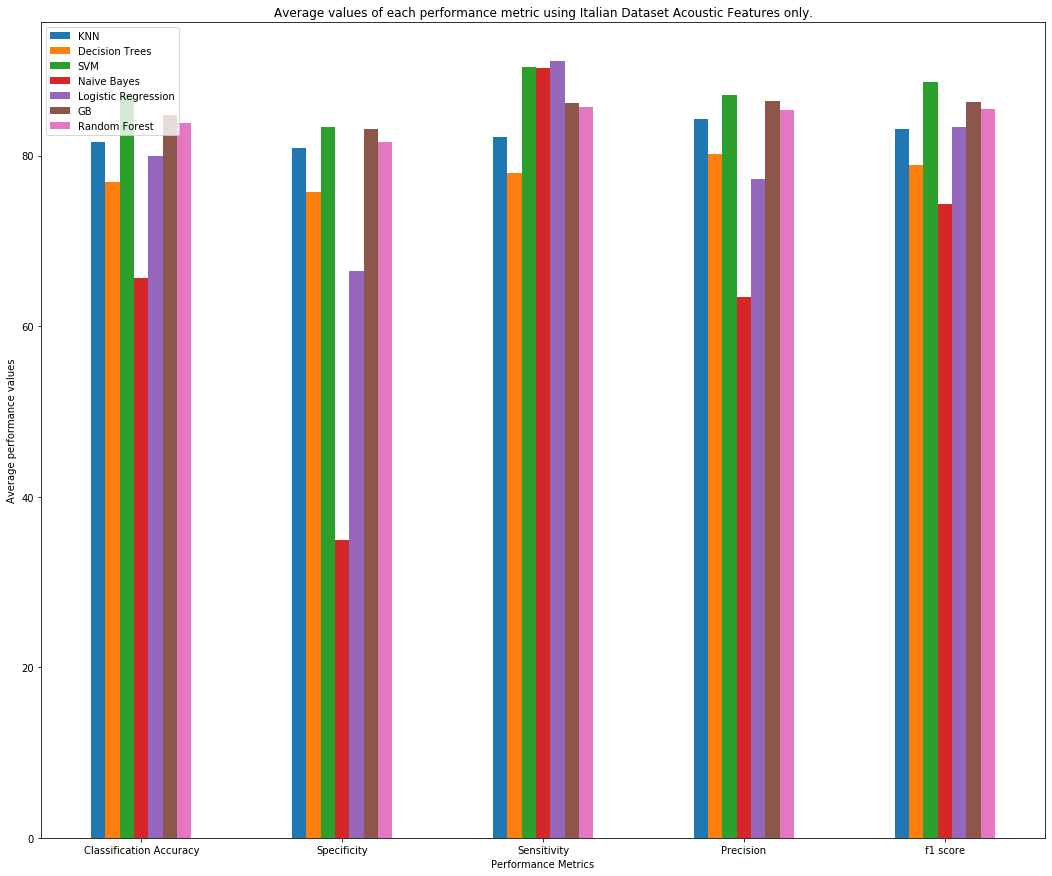

In [47]:
df_comparison.plot(kind="bar", figsize=(18, 15))
plt.xticks(rotation=0)
plt.ylabel("Average performance values")
plt.title("Average values of each performance metric using Italian Dataset Acoustic Features only.")

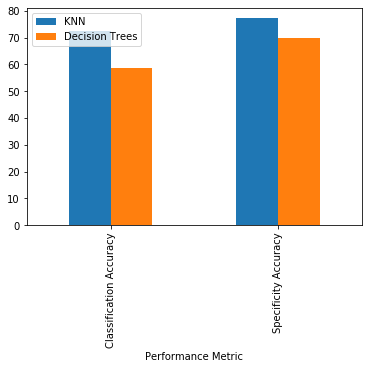

In [82]:
df_comparison[['KNN','Decision Trees']].plot(kind="bar")

In [66]:
k_list

,Loops,fold 1,fold 2,fold 3,fold 4,mean accuracy
0,1,60.0,77.777778,88.888889,66.666667,73.333333
1,2,70.0,66.666667,88.888889,77.777778,75.833333
2,3,80.0,77.777778,66.666667,66.666667,72.777778
3,4,60.0,77.777778,44.444444,88.888889,67.777778
4,5,80.0,88.888889,77.777778,55.555556,75.555556
5,6,80.0,55.555556,66.666667,77.777778,70.000000
6,7,60.0,77.777778,66.666667,88.888889,73.333333
7,8,80.0,44.444444,77.777778,77.777778,70.000000
8,9,90.0,66.666667,77.777778,66.666667,75.277778
9,10,60.0,77.777778,88.888889,77.777778,76.111111


In [67]:
k_nb_list

,Loops,fold 1,fold 2,fold 3,fold 4,mean accuracy
0,1,70.0,88.888889,55.555556,66.666667,70.277778
1,2,60.0,77.777778,66.666667,66.666667,67.777778
2,3,80.0,44.444444,77.777778,66.666667,67.222222
3,4,60.0,88.888889,44.444444,100.000000,73.333333
4,5,80.0,55.555556,66.666667,66.666667,67.222222
5,6,70.0,55.555556,88.888889,66.666667,70.277778
6,7,90.0,77.777778,55.555556,77.777778,75.277778
7,8,60.0,55.555556,88.888889,66.666667,67.777778
8,9,80.0,66.666667,55.555556,77.777778,70.000000
9,10,60.0,55.555556,88.888889,66.666667,67.777778
